# Generating SQL for SQLite using Ollama, ChromaDB
This notebook runs through the process of using the `vanna` Python package to generate SQL using AI (RAG + LLMs) including connecting to a database and training. If you're not ready to train on your own database, you can still try it using a sample [SQLite database](app.md).

## Setup

In [1]:
import warnings
import re

warnings.filterwarnings('ignore', category=DeprecationWarning, message='^Number of requested results')
# warnings.filterwarnings('ignore', category=DeprecationWarning, message=re.escape(r'^Some regex pattern'))

import os

import re
from time import time
from datetime import datetime 

from vanna.ollama import Ollama
from vanna.chromadb.chromadb_vector import ChromaDB_VectorStore
from vanna.utils import snake_case

In [2]:
model_name = 'deepseek-coder-v2' # "codegeex4" # "llama3" # "qwen2.5" # 
CONFIG = {
    'model': model_name,   
}

file_db = "~/Downloads/datasets/chinook.db"


clean_and_train = True  # False  

sql_id = 1

allow_llm_to_see_data = True
# allow_llm_to_see_data (bool): Whether to allow the LLM to see the data (for the purposes of introspecting the data to generate the final SQL).

In [3]:
class MyVanna(ChromaDB_VectorStore, Ollama):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        Ollama.__init__(self, config=config)

In [4]:
vn = MyVanna(config=CONFIG)

In [5]:
hostname = os.uname().nodename
print("Hostname:", hostname)

Hostname: papa-game


In [6]:
file_db = os.path.abspath(os.path.expanduser(file_db))
vn.connect_to_sqlite(file_db)

In [7]:
vn.run_sql_is_set

True

In [8]:
if clean_and_train:
    vn.remove_collection()

## Training

### [SQLite sample database](https://www.sqlitetutorial.net/sqlite-sample-database/)

You only need to train once. Do not train again unless you want to add more training data.

In [9]:
df_ddl = vn.run_sql("SELECT type, sql FROM sqlite_master WHERE sql is not null")

In [10]:
df_ddl

,type,sql
0,table,"CREATE TABLE ""albums""\r\n(\r\n [AlbumId] IN..."
1,table,"CREATE TABLE sqlite_sequence(name,seq)"
2,table,"CREATE TABLE ""artists""\r\n(\r\n [ArtistId] ..."
3,table,"CREATE TABLE ""customers""\r\n(\r\n [Customer..."
4,table,"CREATE TABLE ""employees""\r\n(\r\n [Employee..."
5,table,"CREATE TABLE ""genres""\r\n(\r\n [GenreId] IN..."
6,table,"CREATE TABLE ""invoices""\r\n(\r\n [InvoiceId..."
7,table,"CREATE TABLE ""invoice_items""\r\n(\r\n [Invo..."
8,table,"CREATE TABLE ""media_types""\r\n(\r\n [MediaT..."
9,table,"CREATE TABLE ""playlists""\r\n(\r\n [Playlist..."


In [11]:
if clean_and_train:
    for ddl in df_ddl['sql'].to_list():
        # ddl = strip_brackets(ddl)
        vn.train(ddl=ddl)

    # Sometimes you may want to add documentation about your business terminology or definitions.
    vn.train(documentation="In the chinook database invoice means order")

    doc_str = """
    In the 'customers' table, address column names do not have 'Billing' prefix, 
    e.g. country column name is 'country', not 'BillingCountry'
    """
    vn.train(documentation=doc_str)




Adding ddl: CREATE TABLE "albums"
(
    [AlbumId] INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    [Title] NVARCHAR(160)  NOT NULL,
    [ArtistId] INTEGER  NOT NULL,
    FOREIGN KEY ([ArtistId]) REFERENCES "artists" ([ArtistId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)


Adding ddl: CREATE TABLE sqlite_sequence(name,seq)


Adding ddl: CREATE TABLE "artists"
(
    [ArtistId] INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    [Name] NVARCHAR(120)
)


Adding ddl: CREATE TABLE "customers"
(
    [CustomerId] INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    [FirstName] NVARCHAR(40)  NOT NULL,
    [LastName] NVARCHAR(20)  NOT NULL,
    [Company] NVARCHAR(80),
    [Address] NVARCHAR(70),
    [City] NVARCHAR(40),
    [State] NVARCHAR(40),
    [Country] NVARCHAR(40),
    [PostalCode] NVARCHAR(10),
    [Phone] NVARCHAR(24),
    [Fax] NVARCHAR(24),
    [Email] NVARCHAR(60)  NOT NULL,
    [SupportRepId] INTEGER,
    FOREIGN KEY ([SupportRepId]) REFERENCES "employees" ([EmployeeId]) 
		ON DELETE NO

In [12]:
# show training data
training_data = vn.get_training_data()
training_data

,id,dataset,question,content,training_data_type
0,020848a7-bac7-53cf-9af9-ca0f8e540216-ddl,default,None,"CREATE INDEX IFK_EmployeeReportsTo ON ""employe...",ddl
1,02ee8d00-a7dd-5598-b62b-e3a06084dbda-ddl,default,None,"CREATE TABLE ""playlists""\r\n(\r\n PlaylistI...",ddl
2,039a70d7-499f-57e5-9cff-73e7c23dd2b3-ddl,default,None,"CREATE TABLE ""media_types""\r\n(\r\n MediaTy...",ddl
3,0f11423b-66c8-5ba4-8e59-2e4f617db70e-ddl,default,None,"CREATE TABLE ""invoices""\r\n(\r\n InvoiceId ...",ddl
4,1323a585-b921-528b-a12c-54697d3801d3-ddl,default,None,"CREATE TABLE ""employees""\r\n(\r\n EmployeeI...",ddl
5,1b4e1e26-6cfa-573b-94b7-055aa1257b40-ddl,default,None,"CREATE INDEX IFK_CustomerSupportRepId ON ""cust...",ddl
6,24ecfae0-fd59-599e-b6a0-b3ac0fa44dd1-doc,default,None,"\n In the 'customers' table, address column...",documentation
7,29a795c2-f536-548c-85b1-494e94c547c4-ddl,default,None,"CREATE TABLE ""albums""\r\n(\r\n AlbumId INTE...",ddl
8,38197d19-a90b-5ebe-b51d-eeee8760b334-ddl,default,None,"CREATE TABLE ""playlist_track""\r\n(\r\n Play...",ddl
9,4bbdce6c-4cbd-53a7-98d6-455b65c23f1c-ddl,default,None,"CREATE INDEX IFK_TrackAlbumId ON ""tracks"" (Alb...",ddl


## Asking the AI
Whenever you ask a new question, it will find the 10 most relevant pieces of training data and use it as part of the LLM prompt to generate the SQL.

### warm-up





# QUESTION :  How many customers are there



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT COUNT(*) AS NumberOfCustomers FROM customers;


[( <SQL> )]
generated SQL statement



SELECT COUNT(*) AS NumberOfCustomers FROM customers;


[( <DataFrame> )]
queried dataframe



,NumberOfCustomers
0,59



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



import plotly.graph_objects as go
import pandas as pd

df = df.head(20) if len(df) > 20 else df

if df['NumberOfCustomers'].nunique() == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['NumberOfCustomers'].iloc[0],
        title={"text": "Number of Customers"}
    ))
else:
    fig = go.Figure(go.Bar(
        x=df['NumberOfCustomers'],
        y=[''] * len(df),
        orientation='h'
    ))

fig.update_layout(title="Number of Customers")

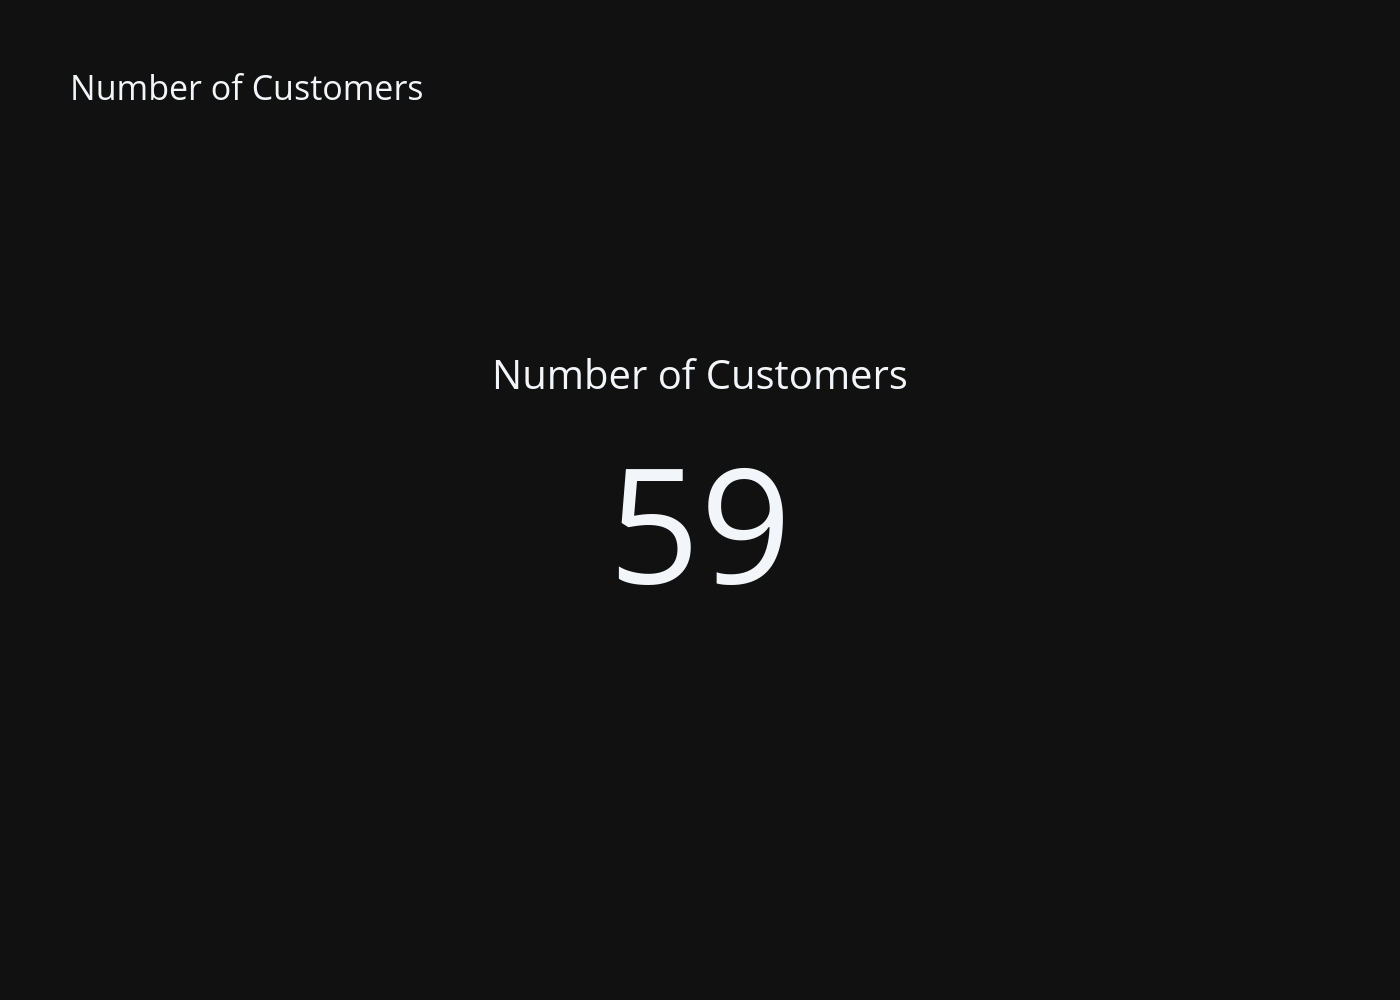

elapsed_time = 6.636954069137573


In [13]:
ts_start = time()
question = "How many customers are there"
resp = vn.ask_adaptive(question=question)
ts_stop = time()
elapsed_time = ts_stop - ts_start
print(f"elapsed_time = {elapsed_time}")

```sql

SELECT name FROM sqlite_master WHERE type = 'table';

```

```sql

SELECT c.CustomerId, SUM(il.Quantity) AS TotalAlbums
FROM Customers c
JOIN invoices i  ON c.CustomerId = i.CustomerId
JOIN invoice_items il ON i.InvoiceId = il.InvoiceId
GROUP BY c.CustomerId
ORDER BY TotalAlbums DESC
LIMIT 5

```


In [14]:
questions = [
    "Can you list all tables in the SQLite database catalog?",
    "which table stores customer's orders",
    "How many customers are there",
    "what are the top 5 countries that customers come from?",
    "List all albums and their corresponding artist names  ",
    """Find all tracks with a name containing "What" (case-insensitive) """,
    "Get the total number of invoices for each customer",
    "Find the total number of invoices per country",
    "List all invoices with a total exceeding $10",
    "Find all invoices since 2010 and the total amount invoiced:",
    "List all employees and their reporting manager's name (if any):",
    " Get the average invoice total for each customer:",
    "Find the top 5 most expensive tracks (based on unit price):",
    "List all genres and the number of tracks in each genre:",
    "Get all genres that do not have any tracks associated with them:",
    "List all customers who have not placed any orders:",
    """ 
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    """,
    "List all customers from Canada and their email addresses:",
    "Find the customer with the most invoices ",
    "Find the customer who bought the most albums in total quantity (across all invoices):",
    """      
        Find the top 5 customers who bought the most albums in total quantity (across all invoices):
        Hint: album quantity is found in invoice_items, 
    """,
    """  
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
    """,
    "Get all playlists containing at least 10 tracks and the total duration of those tracks:",
    "Identify artists who have albums with tracks appearing in multiple genres:",
]

### Loop over questions





# QUESTION  - 2:  Can you list all tables in the SQLite database catalog?



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT name FROM sqlite_master WHERE type='table';


[( <SQL> )]
generated SQL statement



SELECT name FROM sqlite_master WHERE type='table';


[( <DataFrame> )]
queried dataframe



,name
0,albums
1,sqlite_sequence
2,artists
3,customers
4,employees
5,genres
6,invoices
7,invoice_items
8,media_types
9,playlists



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( <Python> )]
generated Plotly code



import pandas as pd
import plotly.graph_objects as go

df = df.head(20) if len(df) > 20 else df

if df.empty:
    fig = go.Figure(go.Indicator(mode="number", value=1, title={"text": "No Tables"}))
else:
    fig = go.Figure(data=[go.Table(header=dict(values=list(df.columns)), cells=dict(values=[[str(i) for i in df[col]] for col in df.columns]))])

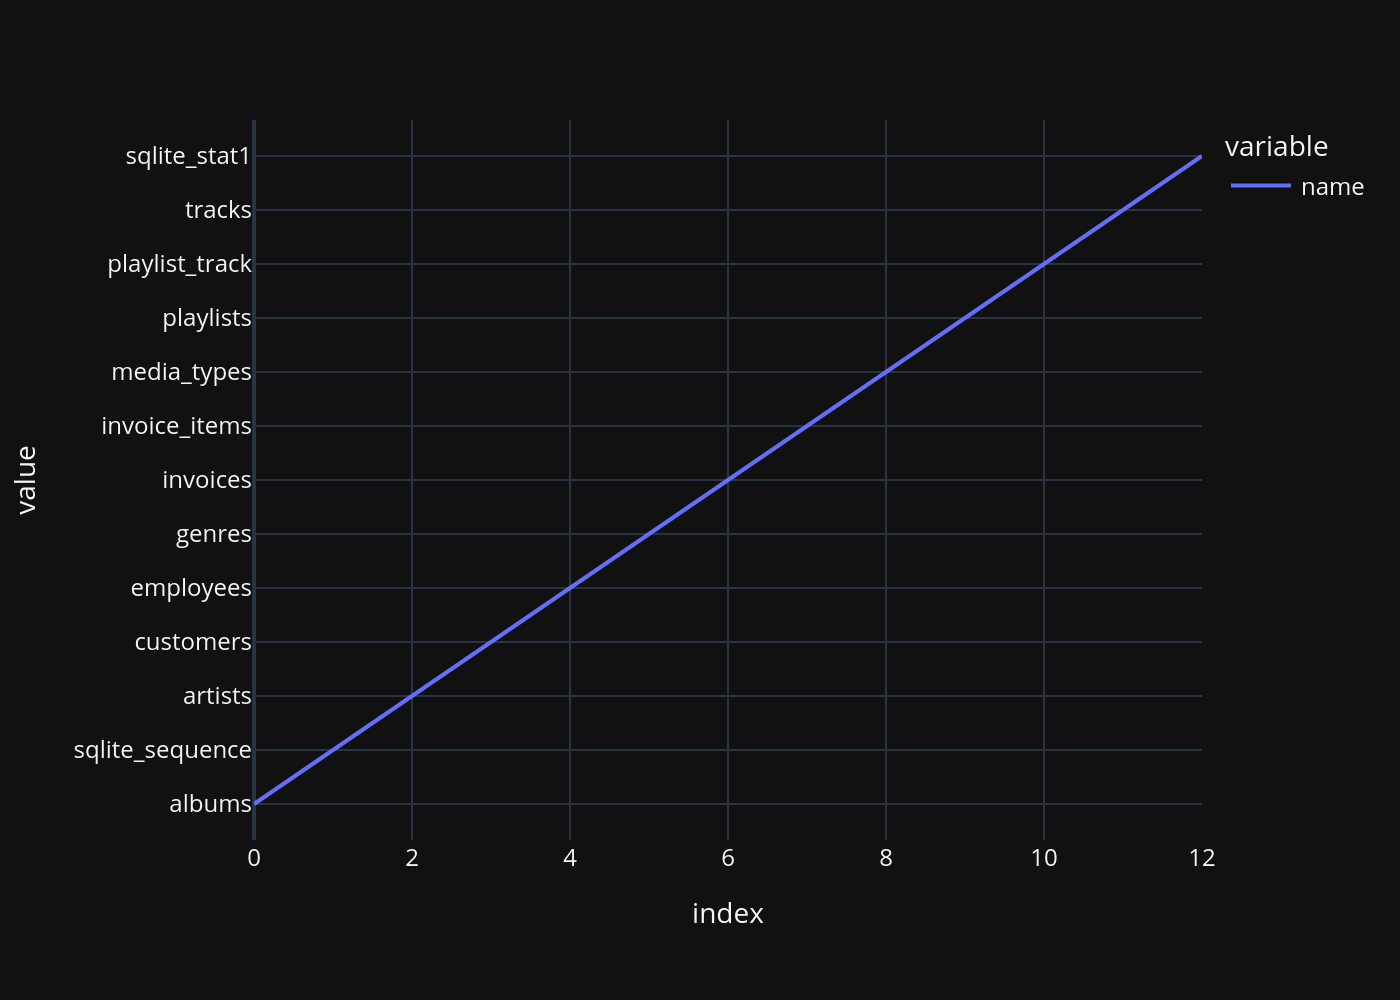





# QUESTION  - 3:  which table stores customer's orders



Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None


[( EXTRACTED SQL )]
SELECT i.*
FROM invoices i
JOIN customers c ON i.CustomerId = c.CustomerId
WHERE c.FirstName = 'John' AND c.LastName = 'Doe';


[( <SQL> )]
generated SQL statement



SELECT i.*
FROM invoices i
JOIN customers c ON i.CustomerId = c.CustomerId
WHERE c.FirstName = 'John' AND c.LastName = 'Doe';


[( <DataFrame> )]
queried dataframe



,InvoiceId,CustomerId,InvoiceDate,BillingAddress,BillingCity,BillingState,BillingCountry,BillingPostalCode,Total



[( RETRY )]
***** 1 *****


Ollama parameters:
model=deepseek-coder-v2:latest,
options={'gpu': True, 'num_ctx': 2048, 'top_p': 0.9, 'top_k': 40, 'seed': 42, 'stop': ['STOP'], 'temperature': 0.2, 'repeat_penalty': 1.1, 'num_predict': 500},
keep_alive=None



In [ ]:
ts_start = time()
for n, question in enumerate(questions):
    # if n != 4: continue
    # if n > 5: continue

    resp = vn.ask_adaptive(question=question, tag_id=n+2)
    # vn.ask(question=question, allow_llm_to_see_data=allow_llm_to_see_data)
    # my_vn_ask(question=question, sql_id=n+2, allow_llm_to_see_data=allow_llm_to_see_data)

ts_stop = time()
elapsed_time = ts_stop - ts_start

### Check completion time

In [ ]:
str_elapsed_sec = f"{elapsed_time:.0f}"
ts = datetime.now().strftime("%Y%m%d-%H%M%S")
print(f"Completed testing:\n================\n LLM model '{model_name}' \n took {str_elapsed_sec} sec\n run on '{hostname}' \n at {ts}")

In [ ]:
file_csv = f"training_data-{model_name}-{str_elapsed_sec}s-{hostname}-{ts}.csv"
file_csv = snake_case(file_csv)

### Save training data

In [ ]:
# show training data
df_training_data = vn.get_training_data()
df_training_data

In [ ]:
df_training_data.to_csv(file_csv, index=False)